Total number of classes 43
Importing Classes
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42  
(38999, 32, 32, 3)
(38999,)
(24959, 32, 32, 3)
(7800, 32, 32, 3)
(6240, 32, 32, 3)
[0, 1413, 1420, 902, 1243, 1187, 276, 928, 909, 965, 1289, 850, 1340, 1388, 497, 407, 268, 754, 750, 124, 230, 234, 233, 348, 171, 978, 381, 146, 349, 184, 282, 490, 152, 450, 248, 772, 248, 128, 1306, 178, 226, 151, 164]


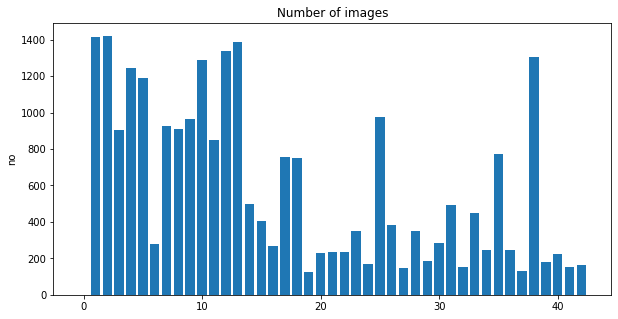

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 4, 4, 30)         

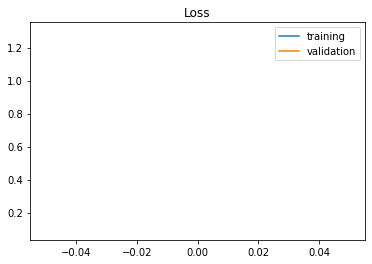

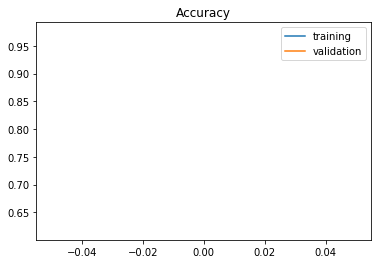

Test Score =  0.1052977880071371
Test Accuracy =  0.970641016960144


In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.optimizers import Adam
import pickle
path = 'Train'
testRatio=0.2
valRatio =0.2
imageDimensions = (32,32,3)

images=[]
classNo =[]
myList = os.listdir(path)
print("Total number of classes", len(myList))
noOfCLasses = len(myList)
print("Importing Classes")
for x in range (1, noOfCLasses):
    myPicList = os.listdir(path+"/"+str(x))
    for y in myPicList:
        curImg = cv2.imread(path+"/"+str(x)+"/"+y)
        curImg = cv2.resize(curImg, (32,32))
        images.append(curImg)
        classNo.append(x)
    print(x, end=" ")
print(" ")


images = np.array(images)
classNo = np.array(classNo)

print(images.shape)
print(classNo.shape)


X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation =train_test_split(X_train,y_train, test_size=valRatio)
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

numOfSamples=[]
for x in range(0, noOfCLasses):
    numOfSamples.append(len(np.where(y_train==x)[0]))
print(numOfSamples)

plt.figure(figsize=(10,5))
plt.bar(range(0, noOfCLasses), numOfSamples)
plt.title("Number of images")
plt.xlabel=("ID")
plt.ylabel("no")
plt.show()
def preProcessing(img):
    img=cv2.cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = img/255
    return img

X_train = np.array(list(map(preProcessing, X_train)))
X_test = np.array(list(map(preProcessing, X_test)))
X_validation = np.array(list(map(preProcessing, X_validation)))

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],X_test.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1],X_validation.shape[2], 1)

dataGen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10)
dataGen.fit(X_train)

y_train = to_categorical(y_train, noOfCLasses)
y_test = to_categorical(y_test, noOfCLasses)
y_validation = to_categorical(y_validation, noOfCLasses)

def myModel():
    noOfFilters = 60
    sizeOfFilter1 = (5,5)
    sizeOfFilter2 = (3,3)
    sizeOfPool = (2,2)
    noOfNode = 500

    model = Sequential()
    model.add((Conv2D(noOfFilters, sizeOfFilter1, input_shape=(imageDimensions[0],
                                                               imageDimensions[1], 1), activation= 'relu')))

    model.add((Conv2D(noOfFilters, sizeOfFilter1, activation='relu')))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    model.add((Conv2D(noOfFilters//2, sizeOfFilter2, activation='relu')))
    model.add((Conv2D(noOfFilters//2, sizeOfFilter2, activation= 'relu')))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(noOfNode, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(noOfCLasses, activation='softmax'))
    model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = myModel()
print(model.summary())
epochVal = 1
stepsPerEpoch = 2000
history = model.fit_generator(dataGen.flow(X_train,y_train,
                                 batch_size=50), steps_per_epoch=stepsPerEpoch, epochs=epochVal,
                              validation_data=(X_validation, y_validation),
                                shuffle=1)

plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel ='epoch'
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel= 'epoch'
plt.show()
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Score = ', score[0])
print('Test Accuracy = ', score[1])


pickle_out = open("model_trained.p", "wb")
pickle.dump(model, pickle_out)
pickle_out.close()